In [1]:
#%% load toolboxes
## general package
import numpy as np
import matplotlib.pyplot as plt 

## package for extracting audio features
import resampy
import fairseq
from scipy.io import wavfile

## package for extracting visual features
import cv2
import torch
import torchvision
from torch import nn
from torchvision import transforms

In [2]:
#%% Define some func.
def load_video(video_path):
    v = cv2.VideoCapture(video_path)
    # check if video is opened successfully
    if not v.isOpened():
        print('Error opening the file.')
        exit(0)
    return v

def video_info(video):
    NFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    Video_FPS = cap.get(cv2.CAP_PROP_FPS)
    Video_Res = [cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT)]
    print('Video dimensions:', Video_Res)
    print('Total frame number:', NFrames)
    print('Video FPS (Frame Per Second):', Video_FPS)
    return NFrames, Video_FPS, Video_Res

In [3]:
#%% Device agnostic code
''' for google colab '''
# device = 'cuda' if torch.cuda.is_available() else 'cpu'  

''' for mac '''
if torch.backends.mps.is_available() & torch.backends.mps.is_built():
    device = 'mps'
else:
    device = 'cpu'

## 1. audio feature extraction (wav2vec 2.0)

Other wav2vec 2.0 model (e.g., wav2vec_small_NFT.pt) can be downloaded via this link: https://github.com/facebookresearch/fairseq/blob/main/examples/wav2vec/README.md

In [13]:
## Load the audio
orig_srate, wav = wavfile.read('Data/Foreign_Language_trigger.wav')
print('the original sample rate of the audio is {} Hz.'.format(orig_srate))

# downsample the audio to 16000Hz
new_srate = 16000
wav = wav[:, 1]
wav = resampy.resample(wav, orig_srate, new_srate)

the original sample rate of the audio is 44100 Hz.


In [14]:
## load wav2vec_base model
checkpoint = torch.load('Data/wav2vec_model/wav2vec_small_NFT.pt')
cfg = fairseq.dataclass.utils.convert_namespace_to_omegaconf(checkpoint['args'])
aud_model = fairseq.models.wav2vec.Wav2Vec2Model.build_model(cfg.model)
aud_model.load_state_dict(checkpoint['model'])
# aud_model.eval()

<All keys matched successfully>

In [15]:
## Feature generation
# input preprocessing
wav = wav[np.newaxis, :]
wav = torch.from_numpy(wav)

# generate transformer-block features
# Here I followed the pipeline of the original paper:
#   - Batches are built by cropping 250k audio samples, or 15.6sec, from each example.
N = 250000
seg_num = int((N - 400) / 320 + 1)
seg_N = np.floor(wav.shape[1] / N)
trs_7 = np.zeros((int(seg_num * seg_N + 644), 768))

for n in range(int(seg_N + 1)): 
    print('current seg number is {}'.format(n))
    if n == int(seg_N):
        wav_seg = wav[:, N * n :]; trs = []
        while len(trs) != 12:
            trs = aud_model.extract_features(source = wav_seg, padding_mask = None)
            trs = trs['layer_results']
        print(len(trs))
        trs_7[seg_num * n :, :] = np.squeeze(trs[6][0].detach().numpy())
    else:
        wav_seg = wav[:, N * n : N * (n + 1)]; trs = []
        while len(trs) != 12:  # avoid the layer dropout
            trs = aud_model.extract_features(source = wav_seg, padding_mask = None)
            trs = trs['layer_results']
        trs_7[seg_num * n : seg_num * (n + 1), :] = np.squeeze(trs[6][0].detach().numpy())

current seg number is 0
current seg number is 1
current seg number is 2
current seg number is 3
current seg number is 4
current seg number is 5
current seg number is 6
current seg number is 7
current seg number is 8
current seg number is 9
current seg number is 10
current seg number is 11
current seg number is 12
current seg number is 13
current seg number is 14
current seg number is 15
current seg number is 16
current seg number is 17
current seg number is 18
current seg number is 19
current seg number is 20
current seg number is 21
current seg number is 22
current seg number is 23
current seg number is 24
current seg number is 25
current seg number is 26
current seg number is 27
current seg number is 28
current seg number is 29
current seg number is 30
current seg number is 31
current seg number is 32
current seg number is 33
current seg number is 34
current seg number is 35
current seg number is 36
current seg number is 37
current seg number is 38
current seg number is 39
current se

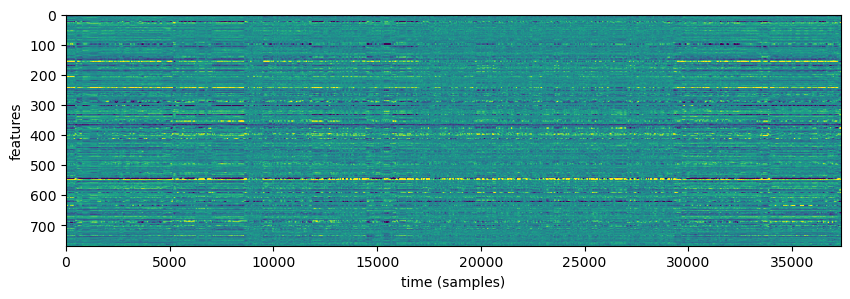

In [31]:
## visualize features
plt.figure(figsize = (10, 3))
plt.imshow(trs_7.transpose(), vmin = -0.5, vmax = 0.5, aspect = 'auto')
plt.xlabel('time (samples)')
plt.ylabel('features')
plt.show()

## 2. visual feature extraction (Vision Transformer)

Please note that the original "forward" function in the "VisionTransformer" class does not retain embeddings from all layers. Therefore, you may need to implement an additional function to enable the following usage:

Please add the above function to "vision_transformer.py" (in line 365) in the torchvision package to make the following code possible.

In [9]:
## load video
cap = load_video('Data/Foreign_Language_trigger.mp4')

## video info
[NFrames, Video_FPS, Video_Res] = video_info(cap)

Video dimensions: [1920.0, 1080.0]
Total frame number: 17916
Video FPS (Frame Per Second): 23.976023976023978


In [10]:
## load ViT model: ViT huge model (32*32 patch)
ViT_model = torchvision.models.vit_h_14(weights = 'IMAGENET1K_SWAG_E2E_V1', feature_extraction_mode = 1)
# ViT_model.state_dict()  # model info
# ViT_model.state_dict().keys()  # layer info

In [12]:
## Feature generation
miu = torch.reshape(torch.tensor([0.485, 0.456, 0.406]), (3, 1, 1))  # used for normalization
sigma = torch.reshape(torch.tensor([0.229, 0.224, 0.225]), (3, 1, 1))  # used for normalization

## movie data preprocessing
vitH16 = np.zeros((NFrames, 1280))

for f in range(NFrames):
    print('current frame is {}'.format(f))
    cap.set(cv2.CAP_PROP_POS_FRAMES, f)
    ret, img = cap.read()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # [H, W, C]
    img = cv2.resize(img, (518, 518), interpolation = cv2.INTER_AREA)  # resizing to [224, 224]
    img = img / 255  # rescale to [0, 1]
    img = torch.tensor(img).permute(2, 0, 1)  # [C, H, W]
    img = (img - miu) / sigma
    img = img[np.newaxis, :, : , :]
    features = ViT_model.my_forward(img.to(torch.float32))
    vitH16[f, :] = features[15].detach().numpy()
    del features

current frame is 0
current frame is 1
current frame is 2
current frame is 3
current frame is 4
current frame is 5
current frame is 6
current frame is 7
current frame is 8
current frame is 9
current frame is 10
current frame is 11
current frame is 12
current frame is 13
current frame is 14
current frame is 15
current frame is 16
current frame is 17
current frame is 18
current frame is 19
current frame is 20
current frame is 21
current frame is 22
current frame is 23
current frame is 24
current frame is 25
current frame is 26
current frame is 27
current frame is 28
current frame is 29
current frame is 30
current frame is 31
current frame is 32
current frame is 33
current frame is 34
current frame is 35
current frame is 36
current frame is 37
current frame is 38
current frame is 39
current frame is 40
current frame is 41
current frame is 42
current frame is 43
current frame is 44
current frame is 45
current frame is 46
current frame is 47
current frame is 48
current frame is 49
current fr

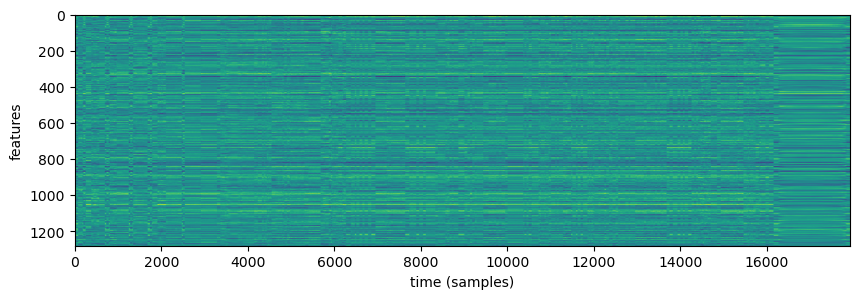

In [14]:
## visualize features
plt.figure(figsize = (10, 3))
plt.imshow(vitH16.transpose(), vmin = -0.5, vmax = 0.5, aspect = 'auto')
plt.xlabel('time (samples)')
plt.ylabel('features')
plt.show()